In [1]:
import pandas as  pd

feature_name_df = pd.read_csv('./datasets/human_activity/features.txt' , sep="\s+", header=None , names=['column_index', 'column_name'])

In [2]:
feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [3]:
feature_name = feature_name_df.iloc[: ,1].values.tolist()

In [4]:
len(feature_name)

561

In [5]:
pd.read_csv('./datasets/human_activity/train/X_train.txt', sep="\s+").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7351 entries, 0 to 7350
Columns: 561 entries, 2.8858451e-001 to -5.8626924e-002
dtypes: float64(561)
memory usage: 31.5 MB


In [6]:
feature_name[:10]

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X']

In [7]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():
    feature_name_df = pd.read_csv('./datasets/human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    X_train = pd.read_csv('./datasets/human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./datasets/human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('./datasets/human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./datasets/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

column_index    42
dtype: int64


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [9]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print(round(accuracy,4))
print('DecisionTreeClassifier 기본 하이퍼파라미터:', dt_clf.get_params())

0.8548
DecisionTreeClassifier 기본 하이퍼파라미터: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [11]:
from sklearn.tree import export_graphviz
# export_graohviz() 호출결과로 out_file로 지정된 tree.dot파일 생성
export_graphviz(dt_clf,out_file="human_tree.dot",class_names=["1","2","3","4","5","6"],
               feature_names=feature_name,impurity=True,filled=True)

import graphviz

with open('human_tree.dot') as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)

In [12]:
graph.render(filename='humanity_tree_img', directory='./', format='png')

'humanity_tree_img.png'

In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
         }

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: ',round(grid_cv.best_score_, 4))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치:  0.8513
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}


In [15]:
best_dt = grid_cv.best_estimator_

In [16]:
result= best_dt.predict(X_test)
best_accuracy = accuracy_score(y_test, result)
best_accuracy

0.8574821852731591

In [17]:
grid_cv.cv_results_

{'mean_fit_time': array([3.33439121, 4.90158677, 5.81937585, 5.93143649, 6.8015996 ,
        6.92126112, 6.33642993]),
 'std_fit_time': array([0.16554022, 1.24337319, 0.30361514, 0.39313096, 0.64265262,
        0.93724372, 0.7216578 ]),
 'mean_score_time': array([0.01439295, 0.01959372, 0.0151958 , 0.01698732, 0.01539469,
        0.0222908 , 0.01498766]),
 'std_score_time': array([0.00185288, 0.00530757, 0.00159486, 0.00384798, 0.00300528,
        0.01278249, 0.0014182 ]),
 'param_max_depth': masked_array(data=[6, 8, 10, 12, 16, 20, 24],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 6},
  {'max_depth': 8},
  {'max_depth': 10},
  {'max_depth': 12},
  {'max_depth': 16},
  {'max_depth': 20},
  {'max_depth': 24}],
 'split0_test_score': array([0.81373215, 0.82053025, 0.79945615, 0.79469748, 0.79945615,
        0.8028552 , 0.7960571 ]),
 'split1_test_score': array([0.87287559, 0.81985044, 0.

In [18]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
         }

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 , refit=False)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: ',round(grid_cv.best_score_, 4))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치:  0.8513
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}


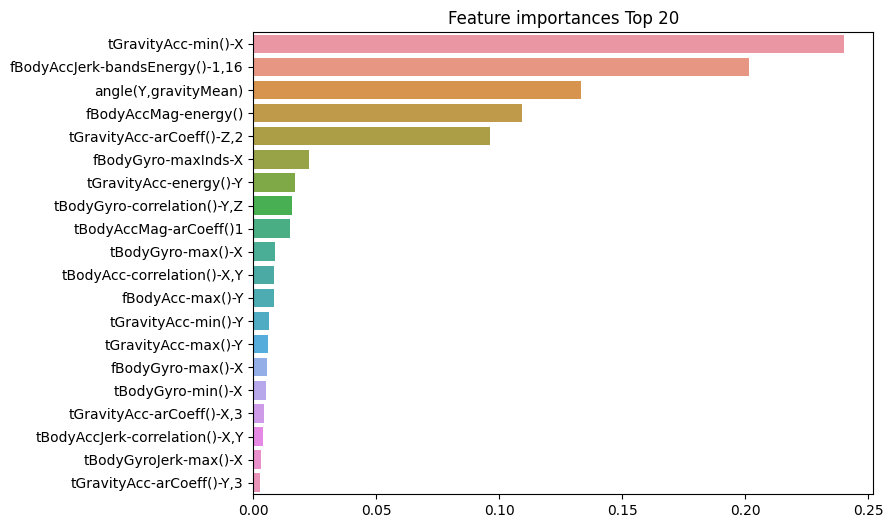

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importances_values = best_dt.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
params = {
    'n_estimators' : [100],
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
         }

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('GridSearchCV 최고 평균 정확도 수치: ',round(grid_cv.best_score_, 4))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)

C:\Users\yim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV 최고 평균 정확도 수치:  0.918
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}


In [22]:
rf_clf_1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, min_samples_split=8, random_state=0,)
rf_clf_1.fit(X_train, y_train)
pred = rf_clf_1.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print('예측정확도:', round(accuracy, 4))

c:\Temp\ipykernel_3256\2654161874.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf_1.fit(X_train, y_train)


예측정확도: 0.9165


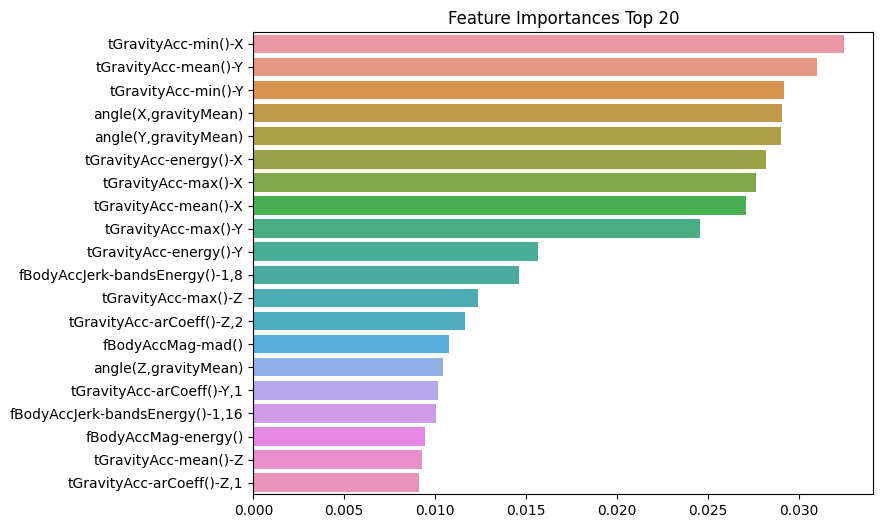

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf_1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test=get_human_dataset()

start_time=time.time()

gb_clf=GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred=gb_clf.predict(X_test)
gb_accuracy=accuracy_score(y_test,gb_pred)

print(gb_accuracy, time.time()-start_time)




0.9389209365456397 2469.9761373996735


In [ ]:
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[100,500],
    'learning_rate':[0.05,0.1]
}
grid_cv=GridSearchCV(gb_clf, param_grid=params,cv=2, verbose=1)
grid_cv.fit(X_train,y_train)
print(grid_cv.best_params_, grid_cv.best_score_)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [ ]:
gb_pred=grid_cv.best_estimator_.predict(X_test)
gb_accuracy=accuracy_score(y_test, gb_pred)
print(gb_accuracy)


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 모델 선언
model = xgb.XGBClassifier() 

# 모델 훈련
model.fit(X_train,y_train) 

# 모델 예측
y_pred = model.predict(y_test)

In [ ]:
xgb.plot_importance(my_model)

In [ ]:
# num_trees : 그림을 여러개 그릴시 그림 번호
  # rankdir : 트리의 방향, 디폴트는 위아래 방향
  # rankdir="LR" : 왼쪽에서 오른쪽 방향으로 트리를 보여준다.
  xgb.plot_tree(my_model, num_trees=0, rankdir='LR')

  fig = plt.gcf()
  fig.set_size_inches(150, 100)

  # 이미지 저장하고 싶다면
  # fig.savefig('tree.png')

  plt.show()